In [372]:
import numpy as np
import torch
import pandas as pd
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero, GCNConv
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import HeteroData

data_folder = "../data/interm/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [373]:
users = pd.read_csv(data_folder + "users.csv")
items = pd.read_csv(data_folder + "items.csv")
ratings = pd.read_csv(data_folder + "ratings.csv")
genres = pd.read_csv("../data/raw/ml-100k/u.genre", delimiter="|", names=["name","index"])

Edges: ratings
Nodes: users, items
Graph type: bipartite

In [374]:
def create_torch_edges(ratings):
    src = ratings["user_id"] - 1
    dst = ratings["item_id"] - 1
    attrs = ratings["rating"]
    
    edge_index = torch.tensor([src, dst], dtype=torch.int64)
    edge_attr = torch.tensor(attrs)
    
    return edge_index, edge_attr

In [375]:
edge_index, edge_attr = create_torch_edges(ratings)

In [376]:
edge_index.shape

torch.Size([2, 100000])

In [377]:
items

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998.0
1678,1679,B. Monkey (1998),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998.0
1679,1680,Sliding Doors (1998),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998.0
1680,1681,You So Crazy (1994),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1994.0


In [378]:
from sentence_transformers import SentenceTransformer

def SequenceEncoder(movie_titles , model_name=None):
    model = SentenceTransformer(model_name, device=device)
    title_embeddings = model.encode(movie_titles, show_progress_bar=True,
                              convert_to_tensor=True, device=device)
    
    return title_embeddings.to("cpu")

item_title = SequenceEncoder(items["movie_title"], model_name='all-MiniLM-L6-v2')
item_genres = torch.tensor(items[genres.name].to_numpy(), dtype=torch.bool)
item_release_year = torch.tensor(items["release_year"].to_numpy()[:,np.newaxis], dtype=torch.int32)

item_x = torch.cat((item_title, item_genres), dim=-1).float()

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

In [379]:
users

,user_id,age,zip_code,male,female,occupation_technician,occupation_other,occupation_writer,occupation_executive,occupation_administrator,...,occupation_librarian,occupation_homemaker,occupation_artist,occupation_engineer,occupation_marketing,occupation_none,occupation_healthcare,occupation_retired,occupation_salesman,occupation_doctor
0,1,24,85711,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,53,94043,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,23,32067,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,24,43537,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,33,15213,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,26,33319,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
939,940,32,02215,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
940,941,20,97229,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
941,942,48,78209,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [380]:
users.zip_code.to_numpy()

array(['85711', '94043', '32067', '43537', '15213', '98101', '91344',
       '05201', '01002', '90703', '30329', '06405', '29206', '55106',
       '97301', '10309', '06355', '37212', '02138', '95660', '30068',
       '40206', '48197', '94533', '55107', '21044', '30030', '55369',
       '94043', '55436', '10003', '78741', '27510', '42141', '42459',
       '93117', '55105', '54467', '01040', '27514', '80525', '17870',
       '20854', '46260', '50233', '46538', '07102', '12550', '76111',
       '52245', '16509', '55105', '55414', '66315', '01331', '46260',
       '84010', '52246', '08403', '06472', '30040', '97214', '75240',
       '43202', '48118', '80521', '60402', '22904', '55337', '60067',
       '98034', '73034', '41850', 'T8H1N', '08816', '02215', '29379',
       '61801', '03755', '52241', '21218', '22902', '44133', '55369',
       '20003', '46005', '89503', '11701', '68106', '78155', '01913',
       '80525', '23112', '71457', '10707', '75206', '98006', '90291',
       '63129', '902

In [381]:
user_ages = torch.tensor(users["age"].to_numpy()[:,np.newaxis], dtype=torch.uint8)
user_sex = torch.tensor(users[["male", "female"]].to_numpy(), dtype=torch.bool)
occupations = [i for i in users.keys() if i.startswith("occupation_")]
user_occupation = torch.tensor(users[occupations].to_numpy(), dtype=torch.bool)
user_x = torch.cat((user_ages, user_sex, user_occupation), dim=-1).float()

In [382]:
data = HeteroData()

# data['user'].num_nodes = len(users)
# data['user'].x = torch.eye(data['user'].num_nodes, device=device)
# del data['user'].num_nodes
data['user'].x = user_x
data['item'].x = item_x
data['user', 'rates', 'item'].edge_index = edge_index
data['user', 'rates', 'item'].edge_label = edge_attr

In [383]:
data = ToUndirected()(data)
del data['item', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.
data = data.to(device)

# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'item')],
    rev_edge_types=[('item', 'rev_rates', 'user')],
)(data)

In [384]:
weight = torch.bincount(train_data['user', 'rates', 'item'].edge_label)
weight = weight.max() / weight
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [385]:
from torch.nn import Dropout
from torch_geometric.nn import GATv2Conv, RGCNConv, HeteroConv, GINConv
from torch_geometric.utils.dropout import *


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types\
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x
class EdgeDecoder(torch.nn.Module):
    def __init__(self, n_factors, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * n_factors, hidden_channels)
        self.dropout1 = Dropout(p=0.5)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.dropout2 = Dropout(p=0.5)
        self.lin3 = Linear(hidden_channels, hidden_channels)
        self.dropout3 = Dropout(p=0.25)
        self.lin4 = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['item'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.dropout1(z)
        z = self.lin2(z).relu()
        z = self.dropout2(z)
        z = self.lin3(z).relu()
        z = self.dropout3(z)
        z = self.lin4(z)
        return z.view(-1)
class Model(torch.nn.Module):
    def __init__(self, n_factors, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(n_factors)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(n_factors, hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        edge_label_index, mask = dropout_edge(edge_label_index, p=0.02, training=self.training)
        z_dict = self.encoder(x_dict, edge_index_dict)
        output = self.decoder(z_dict, edge_label_index)
        output = torch.sigmoid(output)
        output = output * 4 + 1
        return output, mask
model = Model(n_factors=150, hidden_channels=200).to(device)
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [386]:
print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rates__item): SAGEConv((-1, -1), 150, aggr=mean)
      (item__rev_rates__user): SAGEConv((-1, -1), 150, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__item): SAGEConv((-1, -1), 150, aggr=mean)
      (item__rev_rates__user): SAGEConv((-1, -1), 150, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=300, out_features=200, bias=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=200, out_features=200, bias=True)
    (dropout2): Dropout(p=0.5, inplace=False)
    (lin3): Linear(in_features=200, out_features=200, bias=True)
    (dropout3): Dropout(p=0.25, inplace=False)
    (lin4): Linear(in_features=200, out_features=1, bias=True)
  )
)


In [387]:
from torch.nn.functional import mse_loss
from torch.nn import MSELoss

loss_f = MSELoss()

def train():
    model.train()
    optimizer.zero_grad()
    pred, mask = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'rates', 'item'].edge_label_index)
    target = train_data['user', 'rates', 'item'].edge_label
    loss = loss_f(pred, target[mask].float()).pow(2)
    loss.backward()
    optimizer.step()
    return float(loss)

In [388]:
@torch.no_grad()
def test(data):
    model.eval()
    pred, _ = model(data.x_dict, data.edge_index_dict,
                 data['user', 'rates', 'item'].edge_label_index)
    target = data['user', 'rates', 'item'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [390]:
from tqdm import tqdm

t = tqdm(range(1, 10_000))
for epoch in t:
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    t.set_postfix_str(f"Loss: {loss:.4f}, Train: {train_rmse:.4f}, Val: {val_rmse:.4f}, Test: {test_rmse:.4f}")
    # print(f'Epoch: {epoch:03d})

100%|██████████| 9999/9999 [06:13<00:00, 26.80it/s, Loss: 0.3800, Train: 0.9210, Val: 1.1300, Test: 1.1214]


In [405]:
torch.save(model, "../models/gnn_model.pt")
torch.save(data.metadata(), "../models/hetero_data_metadata")

In [391]:
print(len(items))
print(items["movie_id"].max())

1682
1682


In [392]:

model.eval()
total_users = len(users)
total_movies = len(items)
movie_recs = []
for user_id in tqdm(range(0, total_users)):
    all_movie_ids = torch.arange(total_movies)
    seen_movie_ids = ratings[ratings["user_id"] == user_id + 1]["item_id"].unique()
    seen_movie_ids = np.array(seen_movie_ids) - 1

    check_movies = []
    for i in all_movie_ids:
        if not np.any(seen_movie_ids == i.item()):
            check_movies.append(i.item())
    check_movies = torch.tensor(check_movies)

    user_row = torch.tensor([user_id] * check_movies.shape[0])
    edge_label_index = torch.stack([user_row, check_movies], dim=0)
    pred, _ = model(data.x_dict, data.edge_index_dict,
             edge_label_index)
    # print("Max-min diff:", torch.max(pred) - torch.min(pred))
    # we will only select movies for the user where the predicting rating is =5
    rec_movie_ids = torch.argsort(pred, descending=True)[:10]
    top_ten_recs = [(check_movies[rec_movies].item() + 1, pred[rec_movies].item()) for rec_movies in rec_movie_ids.tolist()] 
    movie_recs.append({'user': user_id + 1, 'rec_movies': top_ten_recs})

100%|██████████| 943/943 [00:12<00:00, 73.29it/s]


In [393]:
[{'user': d['user'], 'recs': sorted([r for r, f in d['rec_movies']])} for d in movie_recs]

[{'user': 1, 'recs': [313, 320, 408, 513, 603, 857, 915, 970, 1553, 1629]},
 {'user': 2,
  'recs': [1368, 1466, 1479, 1553, 1554, 1561, 1562, 1573, 1633, 1647]},
 {'user': 3,
  'recs': [853, 857, 915, 1064, 1368, 1482, 1560, 1573, 1586, 1641]},
 {'user': 4, 'recs': [370, 563, 645, 757, 915, 1036, 1322, 1368, 1482, 1560]},
 {'user': 5, 'recs': [268, 513, 544, 691, 752, 844, 1194, 1280, 1410, 1599]},
 {'user': 6,
  'recs': [1122, 1445, 1448, 1460, 1546, 1553, 1578, 1585, 1645, 1650]},
 {'user': 7,
  'recs': [313, 408, 1122, 1169, 1370, 1382, 1467, 1523, 1553, 1600]},
 {'user': 8, 'recs': [169, 404, 515, 528, 622, 625, 626, 966, 1501, 1560]},
 {'user': 9, 'recs': [64, 113, 114, 178, 192, 357, 408, 513, 1358, 1524]},
 {'user': 10,
  'recs': [113, 867, 958, 1266, 1445, 1465, 1524, 1549, 1554, 1578]},
 {'user': 11,
  'recs': [113, 114, 958, 1064, 1465, 1466, 1553, 1562, 1586, 1588]},
 {'user': 12, 'recs': [75, 496, 645, 694, 857, 915, 1084, 1368, 1465, 1553]},
 {'user': 13,
  'recs': [31, 51

In [394]:
user = 1

In [395]:
movie_ids = ratings[ratings.user_id == user].iterrows()
for i in sorted(movie_ids, key=lambda x: x[1].rating, reverse=True):
    _, row = i
    item = items[items["movie_id"] == row.item_id]
    mean_rating = ratings[ratings["item_id"] == row.item_id]["rating"].mean()
    print(item["movie_title"].tolist()[0], row.rating, str(mean_rating)[:3])

Groundhog Day (1993) 5 3.7
Delicatessen (1991) 5 3.8
Pillow Book, The (1995) 5 3.6
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) 5 4.1
Shawshank Redemption, The (1994) 5 4.4
Star Trek: The Wrath of Khan (1982) 5 3.8
Wallace & Gromit: The Best of Aardman Animation (1996) 5 4.4
Breaking the Waves (1996) 5 3.7
Three Colors: Blue (1993) 5 4.0
Good, The Bad and The Ugly, The (1966) 5 3.8
Raiders of the Lost Ark (1981) 5 4.2
Jurassic Park (1993) 5 3.7
Mars Attacks! (1996) 5 2.8
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) 5 3.5
Terminator 2: Judgment Day (1991) 5 4.0
Contact (1997) 5 3.8
Hudsucker Proxy, The (1994) 5 3.5
Brazil (1985) 5 3.8
Kids in the Hall: Brain Candy (1996) 5 3.0
Usual Suspects, The (1995) 5 4.3
Postino, Il (1994) 5 3.9
Dolores Claiborne (1994) 5 3.3
Swingers (1996) 5 3.8
Alien (1979) 5 4.0
Young Frankenstein (1974) 5 3.9
Kolya (1996) 5 3.9
Nightmare Before Christmas, The (1993) 5 3.5
Bound (1996) 5 3.8
Remains of the Day, The (1993) 5 3.9
Dead Poets 

In [396]:
for i, r in movie_recs[user - 1]["rec_movies"]:
    movie = items[items["movie_id"] == i]
    movie_id = movie["movie_id"].tolist()[0]
    mean_rating = ratings[ratings["item_id"] == movie_id]["rating"].mean()
    rated = ratings[ratings["item_id"] == movie_id]["user_id"].notnull().sum()
    print(movie["movie_title"].tolist()[0], str(r)[:3], str(mean_rating)[:3], rated)

Primary Colors (1998) 4.3 3.9 13
Paris Was a Woman (1995) 4.2 3.0 1
Titanic (1997) 4.1 4.2 350
Close Shave, A (1995) 4.0 4.4 112
Nico Icon (1995) 4.0 4.0 2
Underneath, The (1995) 3.9 2.7 4
Rear Window (1954) 3.9 4.3 209
Third Man, The (1949) 3.8 4.3 72
Hear My Song (1991) 3.8 3.2 8
Paradise Lost: The Child Murders at Robin Hood Hills (1996) 3.8 4.0 20


In [397]:
movie_recommended_count = {}
for row in movie_recs:
    for movie_id, _ in row["rec_movies"]:
        if movie_id not in movie_recommended_count:
            movie_recommended_count[movie_id] = 0
        movie_recommended_count[movie_id] += 1
count = movie_recommended_count.items()
movie_recommended_count = sorted(count, key=lambda x: x[1], reverse=True)

In [398]:
for movie_id, count in movie_recommended_count:
    movie_title = items[items["movie_id"] == movie_id]["movie_title"].item()
    print(movie_title, count)

Underneath, The (1995) 347
Nico Icon (1995) 247
Primary Colors (1998) 243
Metisse (Caf? au Lait) (1993) 223
Paris Was a Woman (1995) 217
Mina Tannenbaum (1994) 209
Wallace & Gromit: The Best of Aardman Animation (1996) 186
Crossfire (1947) 145
Duck Soup (1933) 135
Grand Day Out, A (1992) 134
Spirits of the Dead (Tre passi nel delirio) (1968) 128
Clean Slate (Coup de Torchon) (1981) 128
They Made Me a Criminal (1939) 111
M (1931) 109
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) 107
Third Man, The (1949) 104
Close Shave, A (1995) 100
Mamma Roma (1962) 92
For Whom the Bell Tolls (1943) 92
Dream Man (1995) 88
Usual Suspects, The (1995) 88
Last Summer in the Hamptons (1995) 86
Persuasion (1995) 84
Margaret's Museum (1995) 83
Deceiver (1997) 82
Etz Hadomim Tafus (Under the Domin Tree) (1994) 80
Titanic (1997) 78
Hostile Intentions (1994) 78
Saint of Fort Washington, The (1993) 77
Eye of Vichy, The (Oeil de Vichy, L') (1993) 75
Wrong Trousers, The (1993) 74
Good Will Hunting (19

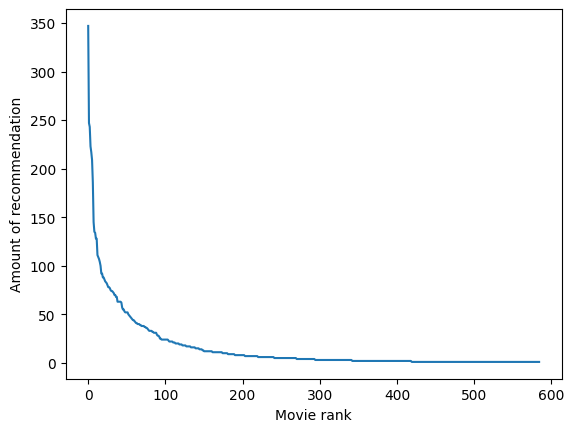

In [399]:
import matplotlib.pyplot as plt

plt.plot([count for _, count in movie_recommended_count])
plt.xlabel("Movie rank")
plt.ylabel("Amount of recommendation")
plt.show()

In [400]:
items[items["movie_id"] == 192]

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
191,192,Raging Bull (1980),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1980.0
